In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# 1. Подготовка временного ряда

In [4]:
passengers = pd.read_csv('data/passengers.csv', index_col=0, parse_dates=True)

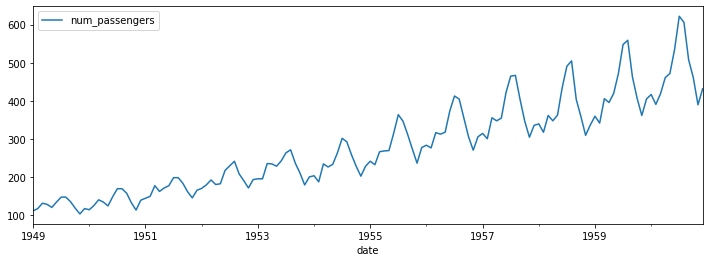

In [5]:
passengers.plot(figsize=(12,4))
plt.show()

Как было отмечено ранее, представленный временной ряд не является стационарным. В нем наблюдаются как тренд, так и сезонность. Кроме того, дисперсия на разных участках ряда не постоянна. Поэтому сначала выполним преобразование Бокса-Кокса.

## 1.1. Преобразование Бокса-Кокса

Следующие две функции возвращают ряд после преобразования Бокса-Кокса с параметром `lmbda` и значение функции правдоподобия соответственно.

In [6]:
def boxcox(y, lmbda):
    if lmbda != 0:
        return (y ** lmbda - 1) / lmbda
    else:
        return np.log(y)

In [7]:
def boxcox_llf(y, lmbda):
    return (lmbda - 1)*np.sum(np.log(y)) - (y.shape[0] / 2)*np.log(np.sum((boxcox(y, lmbda) - 
                                                                    boxcox(y, lmbda).mean())**2 / y.shape[0]))

Воспользуемся функцией `scipy.optimize.minimize`. Здесь оптимизируемый параметр можно передать через lambda-функцию и, поскольку необходимо найти максимум правдоподобия, передадим в качестве оптимизируемой функции `-boxcox_llf(y, lmbda)`.

In [8]:
from scipy.optimize import minimize

In [9]:
minimize(lambda x: -boxcox_llf(passengers['num_passengers'], x), 1)

      fun: 679.5431311684138
 hess_inv: array([[0.03868383]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 10
      nit: 4
     njev: 5
   status: 0
  success: True
        x: array([0.14802242])

Преобразование Бокса-Кокса реализовано также в пакете **SciPy** в виде функций с аналогичными названиями: 
- `scipy.stats.boxcox` принимает на вход временной ряд, а возвращает преобразованный ряд и значение $\lambda$, при котором достигается максимум правдоподобия;
- `scipy.stats.boxcox_llf` возвращает значение функции правдоподобия.

In [10]:
from scipy.stats import boxcox, boxcox_llf

In [11]:
passengers_transformed, lmbda = boxcox(passengers['num_passengers'])

In [12]:
lmbda

0.14802265137037945

In [13]:
boxcox_llf(lmbda, passengers['num_passengers'])

-679.5431311684133

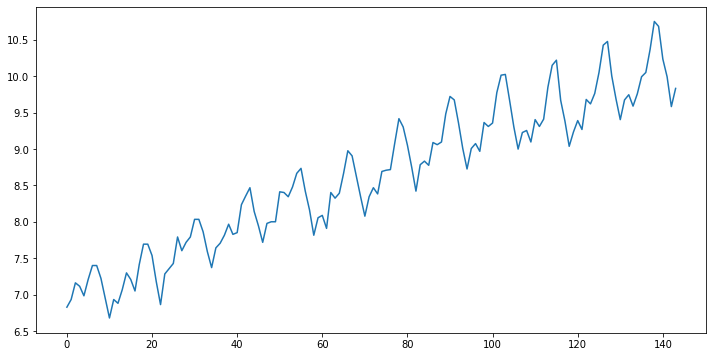

In [14]:
plt.figure(figsize=(12,6))
plt.plot(passengers_transformed)
plt.show()

Дисперсия стабилизировалась. Теперь необходимо избавиться от тренда и сезонности.

## 1.2. Дифференцирование

Для дифференцирования временного ряда в pandas есть функция `pd.Series.diff(lag)`. Преобразуем предварительно полученные значения обратно в `pd.DataFrame()`, а затем проведем сезонное дифференцирование.

In [15]:
y_transformation = pd.DataFrame(passengers['num_passengers'].values, columns=['initial'])
y_transformation['transformed'] = passengers_transformed

In [16]:
y_transformation['seasonal_diff'] = y_transformation['transformed'].diff(12)

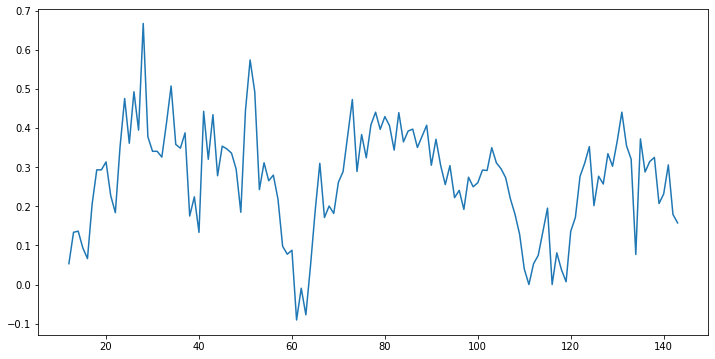

In [17]:
y_transformation['seasonal_diff'].plot(figsize=(12,6))
plt.show()

Полученный ряд не похож на случайный шум, проведем еще обычное дифференцирование.

In [18]:
y_transformation['lag1_diff'] = y_transformation['seasonal_diff'].diff(1)

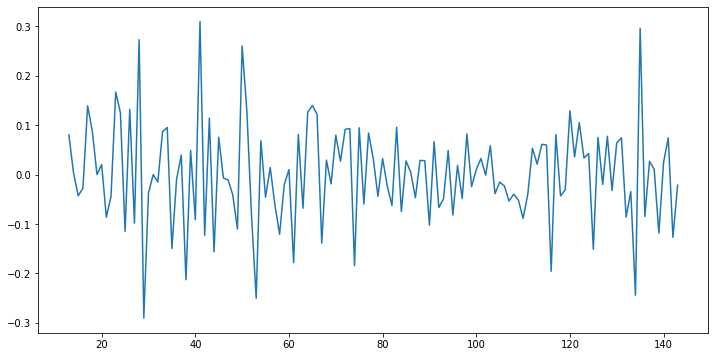

In [19]:
y_transformation['lag1_diff'].plot(figsize=(12,6))
plt.show()

Теперь ряд больше похож на случайный шум. Для надежности можем посмотреть на коррелограмму.

In [20]:
from statsmodels.graphics.tsaplots import plot_acf
# в прежней версии statsmodels.graphics.tsa import plot_acf

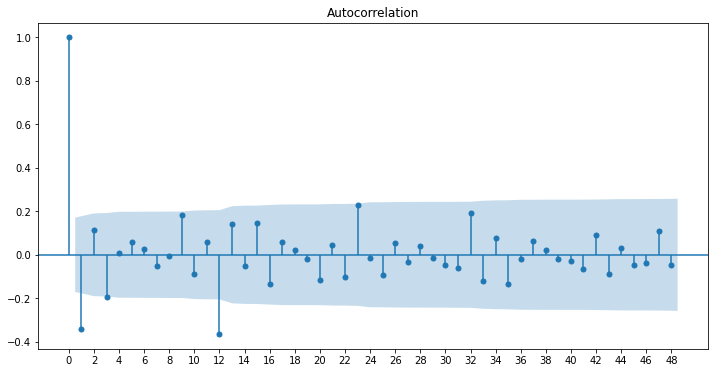

In [21]:
plt.rcParams['figure.figsize'] = (12,6)
plot_acf(y_transformation['lag1_diff'].dropna(), lags=48)
plt.xticks(np.arange(0, 50, 2))
plt.show()

Большая часть значений лежит внутри "коридора", ряд можно считать стационарным.

Для проверки стационарности ряда можно воспользоваться критерием Дики-Фуллера, реализация которого находится в модуле `statsmodels.tsa.stattools`.

In [22]:
from statsmodels.tsa.stattools import adfuller

Данная функция возвращает значение статистики $t$ Дики-Фуллера, p-value, а также значения $t_{крит}$ при заданных уровнях значимости $\alpha$ $0.01, 0.05$ и $0.1$. Если p-value < 0.05, то гипотеза о стационарности ряда не отвергается.

In [23]:
print("Критерий Дики-Фуллера: p=%f" % adfuller(y_transformation['lag1_diff'].dropna())[1])

Критерий Дики-Фуллера: p=0.000304


# 2. Построение модели SARIMA

## 2.1. Обучение модели

Для построения модели SARIMA(2,1,0),(1,1,0) необходимо получить матрицу лаговых значений $y$. Это можно сделать с помощью функции `.shift(lag)` для объектов pandas. Для обучения модели необходимо "сдвинуть" ряд на 1, на 2 и на 12 шагов.

In [24]:
data = pd.DataFrame(y_transformation['lag1_diff']).dropna()
data.columns = ['y']

In [25]:
data['y(t-1)'] = data.shift(1)
data['y(t-2)'] = data['y'].shift(2)
data['y(t-12)'] = data['y'].shift(12)

In [26]:
data.head(16)

,y,y(t-1),y(t-2),y(t-12)
13,0.080310,NaN,NaN,NaN
14,0.002985,0.080310,NaN,NaN
15,-0.042892,0.002985,0.080310,NaN
16,-0.027351,-0.042892,0.002985,NaN
17,0.139146,-0.027351,-0.042892,NaN
18,0.087930,0.139146,-0.027351,NaN
19,0.000000,0.087930,0.139146,NaN
20,0.020352,0.000000,0.087930,NaN
21,-0.086215,0.020352,0.000000,NaN
22,-0.043694,-0.086215,0.020352,NaN


Возьмем только те строки, для которых известны лаговые значения:

In [27]:
data.dropna(inplace=True)

и добавим столбец с единичками:

In [28]:
data['const'] = 1

Для обучения модели определим функцию, которая принимает на вход таблицу нужного вида и возвращает среднеквадратичную ошибку:

In [29]:
def mse(data, params):
    y = data['y']
    y_lag = data.drop('y', axis=1)
    return np.mean((y - np.dot(y_lag, params))**2)

In [30]:
sarima_results = minimize(lambda x: mse(data, [x[0], x[1], x[2], x[3]]), [0, 0, 0, 0])

In [31]:
sarima_params = sarima_results.x

In [32]:
sarima_params

array([-0.37079745, -0.03484399, -0.40541176, -0.00185281])

Предсказание модели на одну точку вперед:

In [33]:
data.values[-1,1:]

array([-0.12683325,  0.0743452 ,  0.07428922,  1.        ])

In [34]:
np.dot(data.values[-1,1:], sarima_params)

0.01246843365343857

## 2.2. Обратное преобразование

В дальнейшем нам понадобится проводить дифференцирование ряда для построения прогноза. Однако, от такого прогноза будет мало толку, ведь полученный ряд будет содержать такие же преобразованные значения. Поэтому необходимо последовательно вернуться к ряду исходных значений.

In [35]:
y_transformation.head(15)

,initial,transformed,seasonal_diff,lag1_diff
0,112,6.827490,NaN,NaN
1,118,6.932822,NaN,NaN
2,132,7.161892,NaN,NaN
3,129,7.114611,NaN,NaN
4,121,6.983787,NaN,NaN
5,135,7.208265,NaN,NaN
6,148,7.399598,NaN,NaN
7,148,7.399598,NaN,NaN
8,136,7.223528,NaN,NaN
9,119,6.949932,NaN,NaN


Перейдем от ряда `lag1_diff` к ряду `seasonal_diff`. В таблице выше это означает, что к `0.080310` необходимо пребавить `0.053251`, к `0.002985` - `0.133562` и т. д. Сдвинем ряд на одно значение с помощью функции `pd.Series.shitf(lag)`:

In [36]:
y_transformation['seasonal_diff_shift'] = y_transformation['seasonal_diff'].shift()

In [37]:
y_transformation.head(15)

,initial,transformed,seasonal_diff,lag1_diff,seasonal_diff_shift
0,112,6.827490,NaN,NaN,NaN
1,118,6.932822,NaN,NaN,NaN
2,132,7.161892,NaN,NaN,NaN
3,129,7.114611,NaN,NaN,NaN
4,121,6.983787,NaN,NaN,NaN
5,135,7.208265,NaN,NaN,NaN
6,148,7.399598,NaN,NaN,NaN
7,148,7.399598,NaN,NaN,NaN
8,136,7.223528,NaN,NaN,NaN
9,119,6.949932,NaN,NaN,NaN


Теперь сложим два полученных ряда, чтобы вернуться к ряду `seasonal_diff` и удалим вспомогательный столбец `seasonal_diff_shift`:

In [38]:
y_transformation['seasonal_diff_res'] = y_transformation['lag1_diff'] + y_transformation['seasonal_diff_shift']

In [39]:
y_transformation.drop(['seasonal_diff_shift'], axis=1, inplace=True)

In [40]:
y_transformation.head(15)

,initial,transformed,seasonal_diff,lag1_diff,seasonal_diff_res
0,112,6.827490,NaN,NaN,NaN
1,118,6.932822,NaN,NaN,NaN
2,132,7.161892,NaN,NaN,NaN
3,129,7.114611,NaN,NaN,NaN
4,121,6.983787,NaN,NaN,NaN
5,135,7.208265,NaN,NaN,NaN
6,148,7.399598,NaN,NaN,NaN
7,148,7.399598,NaN,NaN,NaN
8,136,7.223528,NaN,NaN,NaN
9,119,6.949932,NaN,NaN,NaN


Теперь необходимо перейти от восстановленного ряда `seasonal_diff_res` к ряду `transformed`. Аналогично создадим вспомогательный столбец `transformed_shift`, на этот раз с лагом 12, однако еще одно значение было потеряно при дальнейшем дифференцировании. После создания вспомогательного столбца удалим все строки, содержащие пропуски, сложим значения `seasonal_diff_res` с `transformed_shift` и удалим вспомогательный столбец:

In [41]:
y_transformation['transformed_shift'] = y_transformation['transformed'].shift(12)

In [42]:
y_transformation.dropna(inplace=True)

In [43]:
y_transformation['transformed_res'] = y_transformation['seasonal_diff_res'] + y_transformation['transformed_shift']

In [44]:
y_transformation.drop('transformed_shift', axis=1, inplace=True)

In [45]:
y_transformation.head(10)

,initial,transformed,seasonal_diff,lag1_diff,seasonal_diff_res,transformed_res
13,126,7.066384,0.133562,0.080310,0.133562,7.066384
14,141,7.298438,0.136547,0.002985,0.136547,7.298438
15,135,7.208265,0.093655,-0.042892,0.093655,7.208265
16,125,7.050091,0.066304,-0.027351,0.066304,7.050091
17,149,7.413715,0.205449,0.139146,0.205449,7.413715
18,170,7.692978,0.293380,0.087930,0.293380,7.692978
19,170,7.692978,0.293380,0.000000,0.293380,7.692978
20,158,7.537260,0.313732,0.020352,0.313732,7.537260
21,133,7.177448,0.227516,-0.086215,0.227516,7.177448
22,114,6.863124,0.183823,-0.043694,0.183823,6.863124


Осталось выполнить обратное преобразование Бокса-Кокса. Для этого нет встроенной функции, поэтому ее необходимо реализовать самостоятельно.

In [46]:
def invboxcox(y, lmbda):
    if lmbda != 0:
        return np.exp(np.log(lmbda*y + 1) / lmbda)
    else:
        return np.exp(y)

In [47]:
y_transformation['initial_res'] = invboxcox(y_transformation['transformed_res'], lmbda)

In [48]:
y_transformation.head(10)

,initial,transformed,seasonal_diff,lag1_diff,seasonal_diff_res,transformed_res,initial_res
13,126,7.066384,0.133562,0.080310,0.133562,7.066384,126.0
14,141,7.298438,0.136547,0.002985,0.136547,7.298438,141.0
15,135,7.208265,0.093655,-0.042892,0.093655,7.208265,135.0
16,125,7.050091,0.066304,-0.027351,0.066304,7.050091,125.0
17,149,7.413715,0.205449,0.139146,0.205449,7.413715,149.0
18,170,7.692978,0.293380,0.087930,0.293380,7.692978,170.0
19,170,7.692978,0.293380,0.000000,0.293380,7.692978,170.0
20,158,7.537260,0.313732,0.020352,0.313732,7.537260,158.0
21,133,7.177448,0.227516,-0.086215,0.227516,7.177448,133.0
22,114,6.863124,0.183823,-0.043694,0.183823,6.863124,114.0


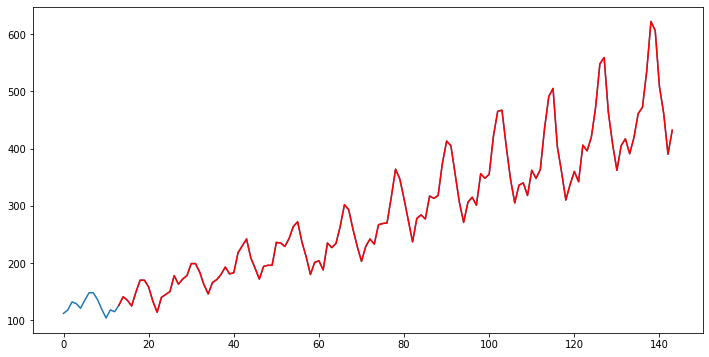

In [49]:
plt.figure(figsize=(12,6))
plt.plot(passengers['num_passengers'].values)
plt.plot(np.concatenate([np.full(13, np.nan), y_transformation['initial_res']]), color='r')
plt.show()

Таким образом, в ходе всех преобразований были потеряны первые 13 значений ряда.


Для своего ряда:
    
1. Выполнить преобразование Бокса-Кокса (лучше использовать свою реализацию, если совсем ломается - взять логарифм).

2. Применить сезонное дифференцирование.

3. После сезонного применить обычное дифференцирование.

4. $*$ Построить аппроксимацию тренда + наивную сезонную модель (см. первое ДЗ) и получить прогноз на один сезонный период.

5. Полученный ряд (и результат прогнозирования$*$) привести к исходному.

In [56]:
electricity = pd.read_csv('data/monthly-electricity-production.csv', index_col=0, parse_dates=True)
electricity.head(10)

,Monthly electricity production in Australia: million kilowatt hours. Jan 1956 ? Aug 1995
Month,
1956-01-01,1254
1956-02-01,1290
1956-03-01,1379
1956-04-01,1346
1956-05-01,1535
1956-06-01,1555
1956-07-01,1655
1956-08-01,1651
1956-09-01,1500


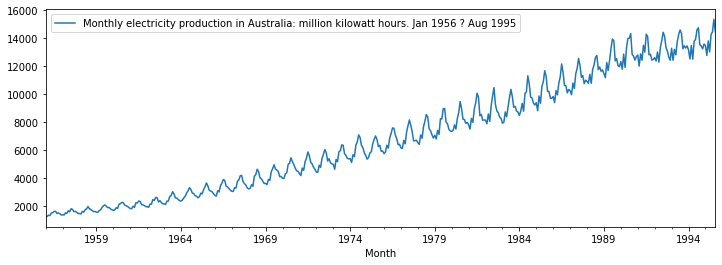

In [57]:
electricity.plot(figsize=(12,4))
plt.show()

## Преобразование Бокса-Кокса

In [59]:
def rboxcox(y, lmbda):
    if lmbda != 0:
        return (y ** lmbda - 1) / lmbda
    else:
        return np.log(y)

In [60]:
def rboxcox_llf(y, lmbda):
    return (lmbda - 1)*np.sum(np.log(y)) - (y.shape[0] / 2)*np.log(np.sum((rboxcox(y, lmbda) - 
                                                                    rboxcox(y, lmbda).mean())**2 / y.shape[0]))

In [61]:
minimize(lambda x: -rboxcox_llf(electricity['Monthly electricity production in Australia: million kilowatt hours. Jan 1956 ? Aug 1995'], x), 1)

      fun: 3921.5658575314665
 hess_inv: array([[0.0058066]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 12
      nit: 5
     njev: 6
   status: 0
  success: True
        x: array([0.38962518])

Проверим полученные значения с помощью встроенных функций

In [62]:
from scipy.stats import boxcox, boxcox_llf

In [63]:
electricity_transformed, lmbda = boxcox(electricity['Monthly electricity production in Australia: million kilowatt hours. Jan 1956 ? Aug 1995'])

In [64]:
lmbda

0.3896252316581785

Значения lambda сошлись

In [65]:
boxcox_llf(lmbda, electricity['Monthly electricity production in Australia: million kilowatt hours. Jan 1956 ? Aug 1995'])

-3921.5658575314665

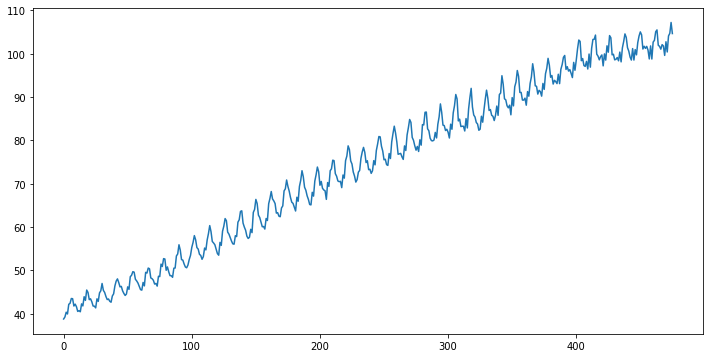

In [66]:
plt.figure(figsize=(12,6))
plt.plot(electricity_transformed)
plt.show()

Полученный рад не сильно отличается от исходного из-за того, что дисперсия у исходного ряда была почти стабилизирована.

## Сезонное дифференцирование

Сезонность = 12 месяцам, каждая строка - это данные за 1 месяц => S = 12.

In [72]:
y_transformation = pd.DataFrame(electricity['Monthly electricity production in Australia: million kilowatt hours. Jan 1956 ? Aug 1995'].values, columns=['electricity'])
y_transformation['transformed'] = electricity_transformed
y_transformation.head(10)

,electricity,transformed
0,1254,38.788412
1,1290,39.246993
2,1379,40.348161
3,1346,39.945069
4,1535,42.178084
5,1555,42.404335
6,1655,43.509757
7,1651,43.466335
8,1500,41.777774
9,1538,42.212136


In [73]:
y_transformation['seasonal_diff'] = y_transformation['transformed'].diff(12)
y_transformation.head(15)

,electricity,transformed,seasonal_diff
0,1254,38.788412,NaN
1,1290,39.246993,NaN
2,1379,40.348161,NaN
3,1346,39.945069,NaN
4,1535,42.178084,NaN
5,1555,42.404335,NaN
6,1655,43.509757,NaN
7,1651,43.466335,NaN
8,1500,41.777774,NaN
9,1538,42.212136,NaN


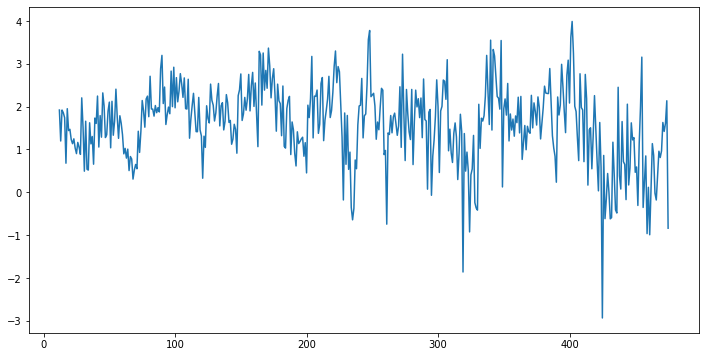

In [74]:
y_transformation['seasonal_diff'].plot(figsize=(12,6))
plt.show()

## Дифференцирование

In [78]:
y_transformation['lag1_diff'] = y_transformation['seasonal_diff'].diff(1)
y_transformation.head(15)

,electricity,transformed,seasonal_diff,lag1_diff
0,1254,38.788412,NaN,NaN
1,1290,39.246993,NaN,NaN
2,1379,40.348161,NaN,NaN
3,1346,39.945069,NaN,NaN
4,1535,42.178084,NaN,NaN
5,1555,42.404335,NaN,NaN
6,1655,43.509757,NaN,NaN
7,1651,43.466335,NaN,NaN
8,1500,41.777774,NaN,NaN
9,1538,42.212136,NaN,NaN


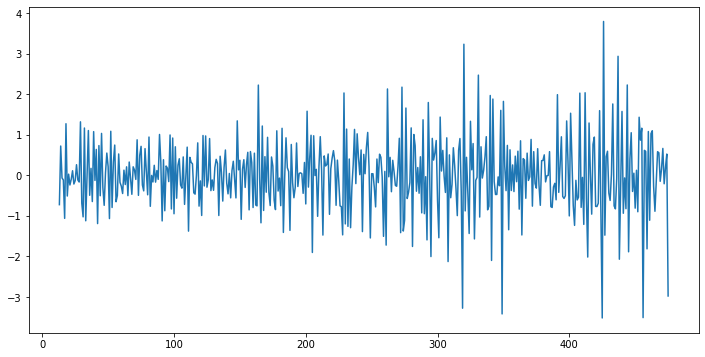

In [79]:
y_transformation['lag1_diff'].plot(figsize=(12,6))
plt.show()

## Прогноз на один сезонный период

## Обратное преобразование

обратное дифференцирование

In [80]:
y_transformation['helpColumn'] = y_transformation['seasonal_diff'].shift()
y_transformation['reverseDif'] = y_transformation['lag1_diff'] + y_transformation['helpColumn']
y_transformation.drop(['helpColumn'], axis=1, inplace=True)
y_transformation.head(15)

,electricity,transformed,seasonal_diff,lag1_diff,reverseDif
0,1254,38.788412,NaN,NaN,NaN
1,1290,39.246993,NaN,NaN,NaN
2,1379,40.348161,NaN,NaN,NaN
3,1346,39.945069,NaN,NaN,NaN
4,1535,42.178084,NaN,NaN,NaN
5,1555,42.404335,NaN,NaN,NaN
6,1655,43.509757,NaN,NaN,NaN
7,1651,43.466335,NaN,NaN,NaN
8,1500,41.777774,NaN,NaN,NaN
9,1538,42.212136,NaN,NaN,NaN


обратное сезонное дифференцирование

In [82]:
y_transformation['helpColumn'] = y_transformation['transformed'].shift(12)
y_transformation.dropna(inplace=True)
y_transformation['reverseSeasonDif'] = y_transformation['reverseDif'] + y_transformation['helpColumn']
y_transformation.drop('helpColumn', axis=1, inplace=True)
y_transformation.head(15)

,electricity,transformed,seasonal_diff,lag1_diff,reverseDif,reverseSeasonDif
13,1387,40.444991,1.197998,-0.723120,1.197998,40.444991
14,1543,42.268799,1.920638,0.722640,1.920638,42.268799
15,1502,41.800801,1.855733,-0.064906,1.855733,41.800801
16,1693,43.919106,1.741022,-0.114710,1.741022,43.919106
17,1616,43.083626,0.679290,-1.061732,0.679290,43.083626
18,1841,45.462068,1.952311,1.273021,1.952311,45.462068
19,1787,44.908184,1.441848,-0.510463,1.441848,44.908184
20,1631,43.248258,1.470484,0.028636,1.470484,43.248258
21,1649,43.444600,1.232465,-0.238019,1.232465,43.444600
22,1586,42.751542,1.135488,-0.096976,1.135488,42.751542


обратное преобразование Бокса-Кокса

In [83]:
def rinvboxcox(y, lmbda):
    if lmbda != 0:
        return np.exp(np.log(lmbda*y + 1) / lmbda)
    else:
        return np.exp(y)

In [85]:
y_transformation['reverseBoxCox'] = rinvboxcox(y_transformation['reverseSeasonDif'], lmbda)
y_transformation.head(10)

,electricity,transformed,seasonal_diff,lag1_diff,reverseDif,reverseSeasonDif,reverseBoxCox
13,1387,40.444991,1.197998,-0.723120,1.197998,40.444991,1387.0
14,1543,42.268799,1.920638,0.722640,1.920638,42.268799,1543.0
15,1502,41.800801,1.855733,-0.064906,1.855733,41.800801,1502.0
16,1693,43.919106,1.741022,-0.114710,1.741022,43.919106,1693.0
17,1616,43.083626,0.679290,-1.061732,0.679290,43.083626,1616.0
18,1841,45.462068,1.952311,1.273021,1.952311,45.462068,1841.0
19,1787,44.908184,1.441848,-0.510463,1.441848,44.908184,1787.0
20,1631,43.248258,1.470484,0.028636,1.470484,43.248258,1631.0
21,1649,43.444600,1.232465,-0.238019,1.232465,43.444600,1649.0
22,1586,42.751542,1.135488,-0.096976,1.135488,42.751542,1586.0


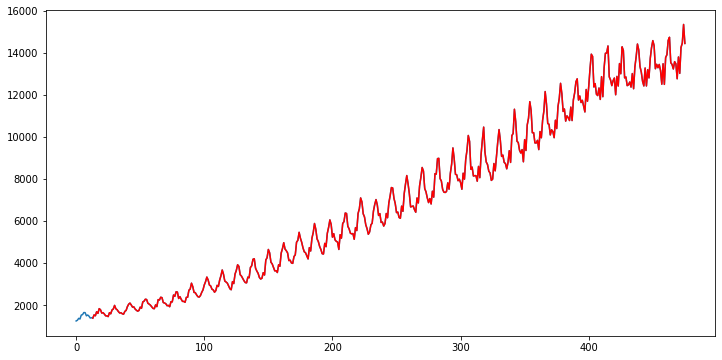

In [87]:
plt.figure(figsize=(12,6))
plt.plot(electricity['Monthly electricity production in Australia: million kilowatt hours. Jan 1956 ? Aug 1995'].values)
plt.plot(np.concatenate([np.full(13, np.nan), y_transformation['reverseBoxCox']]), color='r')
plt.show()